In [23]:
import os
import re
import glob
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
!gdown 1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5

Downloading...
From: https://drive.google.com/uc?id=1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5
To: /home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled.tar
100%|███████████████████████████████████████| 12.3M/12.3M [01:55<00:00, 106kB/s]


In [3]:
tar = tarfile.open("./TUAB_txt_relabelled.tar")
tar.extractall()
tar.close()

In [24]:
main_dataset_dir = '/home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled/v2.0.0/edf/'
train_dataset_dir = main_dataset_dir + 'train/'
test_dataset_dir = main_dataset_dir + 'eval/'
saved_models_dir = "/home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/LightGBM/"

In [22]:
# preprocessing functions

def remove_special_characters(text):
    # Remove everything except letters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    return text


nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text


stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    text = ' '.join(stemmed_tokens)
    return text

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text


def normalize_text(text):
    text = text.lower()
    return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Using LightGBM

In [6]:
class LightGBMTextDataLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_paths = glob.glob(os.path.join(root_dir, '**/*.txt'), recursive=True)
        self.data = []  # This will store tuples of (text, label)
    
    def read_text_file(self, file_path):
        """Reads text file with multiple fallback encodings."""
        encodings = ['utf-8', 'iso-8859-1', 'windows-1252', 'ascii']
        for encoding in encodings:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    return file.read()
            except UnicodeDecodeError:
                continue
        return None  # Return None if all encodings fail

    def preprocess_text(self, text):
        text = normalize_text(text)
        text = remove_special_characters(text)
    
        text = remove_stopwords(text)
        
        text = stem_text(text)
        text = lemmatize_text(text)
        
        return text

    def load_data(self):
        """Loads all text files and labels them based on file path naming."""
        for file_path in self.file_paths:
            label = 1 if 'abnormal' in file_path else 0 if 'normal' in file_path else -1
            text = self.read_text_file(file_path)
            if text:
                processed_text = self.preprocess_text(text)
                self.data.append((processed_text, label))

    def get_dataframe(self):
        """Converts loaded data into a pandas DataFrame."""
        df = pd.DataFrame(self.data, columns=['text', 'label'])
        return df

In [7]:
train_dataloader = LightGBMTextDataLoader(root_dir=train_dataset_dir)
test_dataloader = LightGBMTextDataLoader(root_dir=test_dataset_dir)

train_dataloader.load_data()
test_dataloader.load_data()


train_df = train_dataloader.get_dataframe()
test_df = test_dataloader.get_dataframe()

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
vectorizer = TfidfVectorizer(max_features=1000)

# Fit on training data and transform it
X_train = vectorizer.fit_transform(train_df['text']).toarray()
y_train = train_df['label'].values

# Transform validation data using the same vectorizer
X_val = vectorizer.transform(val_df['text']).toarray()
y_val = val_df['label'].values

# Similarly, transform the test data (do not fit the vectorizer on test data)
X_test = vectorizer.transform(test_df['text']).toarray()
y_test = test_df['label'].values

In [14]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss','auc'],
    'num_leaves': 31,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

num_round = 2000
bst = lgb.train(params,
                train_data,
                num_boost_round=num_round,
                valid_sets=[train_data, val_data],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=50)  # Logs every 50 iterations
                ])

# Save the model
bst.save_model(saved_models_dir + 'lgbm_model.txt')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's binary_logloss: 0.0376928	training's auc: 0.999959	valid_1's binary_logloss: 0.0449454	valid_1's auc: 0.999851
[100]	training's binary_logloss: 0.00316845	training's auc: 1	valid_1's binary_logloss: 0.0152165	valid_1's auc: 0.999946
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0034743	training's auc: 1	valid_1's binary_logloss: 0.015508	valid_1's auc: 0.999946


In [10]:
y_pred_prob = bst.predict(X_test)  # Get model predictions (probabilities)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9964
Precision: 1.0000
Recall: 0.9921
F1 Score: 0.9960


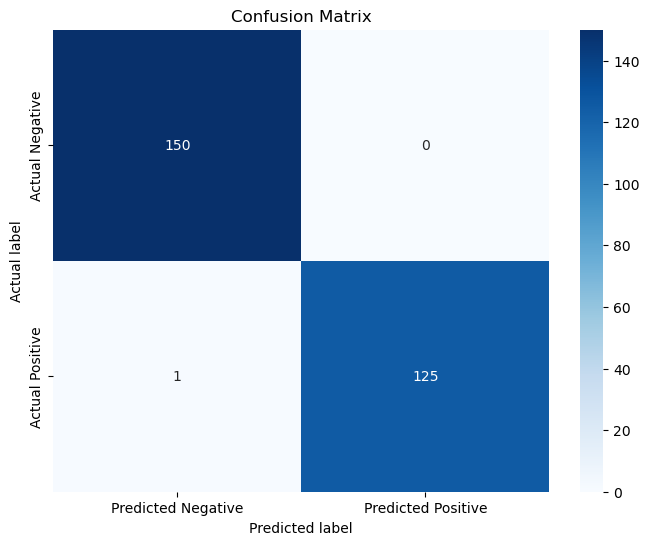

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()